# Mixture EXOME : small bam creation with deep WES samples - patient 986

In [1]:
%load_ext autoreload
%autoreload 2

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import warnings
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.calltable import *

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [2]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
print(config.methods)

['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']


In [3]:
# exome bed file
exomebed = pd.read_csv(os.path.join('data', 'extdata', 'xgen-exome-research-panel-targets_nochr.bed'), sep='\t', header=None)
exomebed.columns = ['chrom', 'startpos', 'endpos', 'gene', 'col4', 'col5']
exomebed_itemlist = []
for ri, row in tqdm(exomebed.iterrows(), total=exomebed.shape[0]):
    #print(row.startpos, row.endpos)
    for i in range(row.startpos, row.endpos + 1):
        #print(str(row.chrom)+'_'+str(i))
        exomebed_itemlist.append(str(row.chrom)+'_'+str(i))
print(len(exomebed_itemlist))
print(len(exomebed_itemlist))
exomebed_itemlist_unique = list(set(exomebed_itemlist))
print(len(exomebed_itemlist_unique))
exomebed.head()


39292129
39292129
39077899


,chrom,startpos,endpos,gene,col4,col5
0,1,69090,70008,469_358463_79501(OR4F5)_1,0,+
1,1,367658,368597,469_360600_729759(OR4F29)_1,0,+
2,1,621095,622034,469_358708_81399(OR4F16)_1,0,-
3,1,861321,861393,473_403203_148398(SAMD11)_3,0,+
4,1,865534,865716,473_403204_148398(SAMD11)_4,0,+


# 1. Positive events: Trusted mutations in exome of patient 986
# Union high ctDNA sample + tissue sample

In [4]:
# get tissue sample calls
calltable_snv, calltable_indel , calltable_snp = get_calltable(os.path.join('data', 'matchedtissue',  'NCC_CRC-986_100215-T1W'), config.methods, save=True, filter='all')
print(calltable_snv.shape)
calltable_snv.head()

NCC_CRC-986_100215-T1W
freebayes
mutect2
retrieving mutect2 0 calls with MinAF tags out of 29455
strelka2
retrieving strelka2 6486 calls with MinAF tags out of 27590
vardict
retrieving vardict 0 calls with f0.01;REJECT;REJECT tags out of 74142
varscan
# calls before using germline calls from GATK Haplotype: 156938 SNV, 97043 INDEL, 39775 SNP
# calls after using germline calls from GATK Haplotype: 152481 SNV, 93859 INDEL, 47416 SNP
final shape SNV: (152481, 30)
final shape INDEL: (93859, 30)
final shape SNP: (47416, 30)
(152481, 30)


,chrom,pos,ref,alt,type,freebayes,freebayes_score,mutect2,mutect2_score,strelka2,...,mutect2_vaf,strelka2_altcov,strelka2_totcov,strelka2_vaf,vardict_altcov,vardict_totcov,vardict_vaf,varscan_altcov,varscan_totcov,varscan_vaf
chrom_pos_ref_alt,,,,,,,,,,,,,,,,,,,,,
10_100081798_A_G,10,100081798,A,G,SNV,True,0.954714,True,1.0,True,...,0.0,0.0,75.0,0.0,0.0,71.0,0.0,0.0,70.0,0.0
10_100099019_C_T,10,100099019,C,T,SNV,True,0.960858,True,1.0,True,...,0.0,0.0,76.0,0.0,NaN,NaN,NaN,0.0,65.0,0.0
10_100111546_A_C,10,100111546,A,C,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,27.0,0.0
10_100206394_A_C,10,100206394,A,C,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,31.0,0.0
10_100301545_C_G,10,100301545,C,G,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,80.0,0.0


In [5]:
# get tissue sample trusted mutations in exome

# trusted mutations all 5 callers: 53
# trusted mutation >= 4 callers: 81

tissue_list = []
for calltable in [calltable_snv, calltable_indel , calltable_snp]:
    tissue_tmp_df = calltable[calltable[config.methods].sum(axis=1) >= 4] # 5 ctDNA callers
    print(tissue_tmp_df.shape)
    tissue_list.append(tissue_tmp_df)
tissue_df = pd.concat(tissue_list)
tissue_df['chrom_pos'] = tissue_df['chrom'].astype('str').str.cat(tissue_df['pos'].astype('str'), sep="_")

mutpos_tissue = list(tissue_df.index)
print(len(mutpos_tissue))

tissue_exome_df = tissue_df[tissue_df['chrom_pos'].isin(exomebed_itemlist_unique)]

mutpos_exome_tissue = list(tissue_exome_df.index)
print(len(mutpos_exome_tissue))

print(tissue_exome_df.shape)
tissue_exome_df.head()

(9341, 30)
(1411, 30)
(0, 30)
10752
115
(115, 31)


,chrom,pos,ref,alt,type,freebayes,freebayes_score,mutect2,mutect2_score,strelka2,...,strelka2_altcov,strelka2_totcov,strelka2_vaf,vardict_altcov,vardict_totcov,vardict_vaf,varscan_altcov,varscan_totcov,varscan_vaf,chrom_pos
chrom_pos_ref_alt,,,,,,,,,,,,,,,,,,,,,
10_117278812_C_T,10,117278812,C,T,SNV,True,0.963804,True,1.0,True,...,0.0,93.0,0.0,NaN,NaN,NaN,0.0,81.0,0.0,10_117278812
10_124583002_C_T,10,124583002,C,T,SNV,True,0.933996,True,1.0,True,...,0.0,78.0,0.0,0.0,75.0,0.0,0.0,73.0,0.0,10_124583002
10_22023011_C_T,10,22023011,C,T,SNV,True,0.965533,True,1.0,True,...,0.0,82.0,0.0,NaN,NaN,NaN,0.0,75.0,0.0,10_22023011
10_79569328_C_T,10,79569328,C,T,SNV,True,0.950007,True,1.0,True,...,0.0,98.0,0.0,NaN,NaN,NaN,0.0,88.0,0.0,10_79569328
11_4107826_C_T,11,4107826,C,T,SNV,True,0.959766,True,1.0,True,...,0.0,70.0,0.0,NaN,NaN,NaN,0.0,65.0,0.0,11_4107826


In [6]:
# get high ctDNA sample calls
calltable_snv, calltable_indel , calltable_snp = get_calltable(os.path.join('data', 'initialsamples',  'NCC_CRC-986_100215_CW_T'), config.methods, save=True, filter='all')
print(calltable_snv.shape)
calltable_snv.head()

NCC_CRC-986_100215_CW_T
freebayes
mutect2
retrieving mutect2 0 calls with MinAF tags out of 41101
strelka2
retrieving strelka2 28757 calls with MinAF tags out of 19249
vardict
retrieving vardict 0 calls with f0.01;REJECT;REJECT tags out of 61552
varscan
calls for caller varscan do not exist. path data/initialsamples/NCC_CRC-986_100215_CW_T/calls/bcbio/NCC_CRC-986_100215_CW_T-N-germline-gatk-haplotype-annotated.vcf.gz not found.
cannot use GATK Haplotype calls to filter germline calls
final shape SNV: (152892, 30)
final shape INDEL: (88338, 30)
final shape SNP: (140956, 30)
(152892, 30)


,chrom,pos,ref,alt,type,freebayes,freebayes_score,mutect2,mutect2_score,strelka2,...,mutect2_vaf,strelka2_altcov,strelka2_totcov,strelka2_vaf,vardict_altcov,vardict_totcov,vardict_vaf,varscan_altcov,varscan_totcov,varscan_vaf
chrom_pos_ref_alt,,,,,,,,,,,,,,,,,,,,,
10_100031904_C_T,10,100031904,C,T,SNV,True,0.894449,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10_100031918_T_C,10,100031918,T,C,SNV,True,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10_100031924_TG_CA,10,100031924,TG,CA,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,0.0,60.0,0.0,NaN,NaN,NaN
10_100031924_T_C,10,100031924,T,C,SNV,True,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10_100031925_G_A,10,100031925,G,A,SNV,True,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# get highctDNA sample trusted mutations in exome

# trusted mutations all 5 callers: 53
# trusted mutation >= 4 callers: 81

highctdna_list = []
for calltable in [calltable_snv, calltable_indel , calltable_snp]:
    highctdna_tmp_df = calltable[calltable[config.methods].sum(axis=1) >= 4] # 5 ctDNA callers
    print(highctdna_tmp_df.shape)
    highctdna_list.append(highctdna_tmp_df)
highctdna_df = pd.concat(highctdna_list)
highctdna_df['chrom_pos'] = highctdna_df['chrom'].astype('str').str.cat(highctdna_df['pos'].astype('str'), sep="_")

mutpos_hightctdna = list(highctdna_df.index)
print(len(mutpos_hightctdna))

highctdna_exome_df = highctdna_df[highctdna_df['chrom_pos'].isin(exomebed_itemlist_unique)]

mutpos_exome_hightctdna = list(highctdna_exome_df.index)
print(len(mutpos_exome_hightctdna))

print(highctdna_exome_df.shape)
highctdna_exome_df.head()

(4840, 30)
(467, 30)
(2172, 30)
7479
81
(81, 31)


,chrom,pos,ref,alt,type,freebayes,freebayes_score,mutect2,mutect2_score,strelka2,...,strelka2_altcov,strelka2_totcov,strelka2_vaf,vardict_altcov,vardict_totcov,vardict_vaf,varscan_altcov,varscan_totcov,varscan_vaf,chrom_pos
chrom_pos_ref_alt,,,,,,,,,,,,,,,,,,,,,
11_64545497_C_T,11,64545497,C,T,SNV,True,0.969072,True,1.000000,True,...,0.0,46.0,0.0,0.0,34.0,0.0,NaN,NaN,NaN,11_64545497
13_47470350_C_T,13,47470350,C,T,SNV,False,NaN,True,1.000000,True,...,0.0,53.0,0.0,0.0,35.0,0.0,0.0,30.0,0.0,13_47470350
13_73357855_C_T,13,73357855,C,T,SNV,True,0.850184,True,0.999996,True,...,0.0,41.0,0.0,0.0,36.0,0.0,NaN,NaN,NaN,13_73357855
13_73636650_C_T,13,73636650,C,T,SNV,True,0.990459,True,1.000000,True,...,0.0,86.0,0.0,0.0,61.0,0.0,0.0,49.0,0.0,13_73636650
15_84488603_G_T,15,84488603,G,T,SNV,True,0.990109,True,1.000000,True,...,0.0,84.0,0.0,0.0,51.0,0.0,NaN,NaN,NaN,15_84488603


In [8]:
# Number of trusted mutations detected

mutpos_exome_tissue = list(tissue_exome_df.index)
print(len(mutpos_exome_tissue))

mutpos_exome_hightctdna = list(highctdna_exome_df.index)
print(len(mutpos_exome_hightctdna))

mutpos_exome_both = list(set(mutpos_exome_tissue) & set(mutpos_exome_hightctdna))
print(len(mutpos_exome_both))

mutpos_exome_union = list(set(mutpos_exome_tissue) | set(mutpos_exome_hightctdna))
print(len(mutpos_exome_union))

115
81
57
139


In [9]:
# Check mutations in tissue is present in high ctDNA sample

# calltable_snv, calltable_indel , calltable_snp = get_calltable(os.path.join('data', 'initialsamples',  'NCC_CRC-986_100215_CW_T'), config.methods, save=True, filter='all')
highctdna_all_df = pd.concat([calltable_snv, calltable_indel , calltable_snp])
highctdna_all_df['chrom_pos'] = highctdna_all_df['chrom'].astype('str').str.cat(highctdna_all_df['pos'].astype('str'), sep="_")
highctdna_exome_all_df = highctdna_all_df[highctdna_all_df['chrom_pos'].isin(exomebed_itemlist_unique)]

In [55]:
count = 0
retrieved_pos = []
for mut in mutpos_exome_tissue:
    if mut not in mutpos_exome_hightctdna:
        try:
            print(highctdna_exome_all_df.loc[mut][config.methods])
            count += 1
            retrieved_pos.append(pd.DataFrame(highctdna_exome_all_df.loc[mut]).T)
        except:
            print('locus not present in high ctDNA ensemble vcf file')
print(count)
retrieved_pos = pd.concat(retrieved_pos)
retrieved_pos

freebayes    False
mutect2      False
strelka2      True
vardict      False
varscan      False
Name: 11_4107826_C_T, dtype: object
freebayes    False
mutect2      False
strelka2      True
vardict      False
varscan      False
Name: 11_48347424_T_A, dtype: object
freebayes    False
mutect2       True
strelka2      True
vardict       True
varscan      False
Name: 11_6292065_C_T, dtype: object
locus not present in high ctDNA ensemble vcf file
locus not present in high ctDNA ensemble vcf file
locus not present in high ctDNA ensemble vcf file
locus not present in high ctDNA ensemble vcf file
locus not present in high ctDNA ensemble vcf file
locus not present in high ctDNA ensemble vcf file
locus not present in high ctDNA ensemble vcf file
locus not present in high ctDNA ensemble vcf file
locus not present in high ctDNA ensemble vcf file
locus not present in high ctDNA ensemble vcf file
locus not present in high ctDNA ensemble vcf file
locus not present in high ctDNA ensemble vcf file
freeba

,chrom,pos,ref,alt,type,freebayes,freebayes_score,mutect2,mutect2_score,strelka2,...,strelka2_altcov,strelka2_totcov,strelka2_vaf,vardict_altcov,vardict_totcov,vardict_vaf,varscan_altcov,varscan_totcov,varscan_vaf,chrom_pos
11_4107826_C_T,11,4107826,C,T,SNP,False,NaN,False,NaN,True,...,0.0,79.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,11_4107826
11_48347424_T_A,11,48347424,T,A,SNV,False,NaN,False,NaN,True,...,0.0,113.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,11_48347424
11_6292065_C_T,11,6292065,C,T,SNV,False,NaN,True,1.0,True,...,0.0,77.0,0.0,0.0,70.0,0.0,NaN,NaN,NaN,11_6292065
19_33698018_C_T,19,33698018,C,T,SNP,False,NaN,True,0.99998,True,...,0.0,62.0,0.0,NaN,NaN,NaN,0.0,36.0,0.0,19_33698018
1_179112067_C_T,1,179112067,C,T,SNP,False,NaN,True,0.999999,True,...,0.0,73.0,0.0,0.0,47.0,0.0,NaN,NaN,NaN,1_179112067
2_70057240_G_A,2,70057240,G,A,SNV,False,NaN,True,0.999982,True,...,0.0,43.0,0.0,0.0,38.0,0.0,NaN,NaN,NaN,2_70057240
2_87070686_C_A,2,87070686,C,A,SNV,False,NaN,True,1.0,False,...,NaN,NaN,NaN,0.0,46.0,0.0,0.0,47.0,0.0,2_87070686
3_23236753_G_A,3,23236753,G,A,SNV,False,NaN,True,1.0,True,...,0.0,80.0,0.0,0.0,53.0,0.0,NaN,NaN,NaN,3_23236753
5_177733904_G_A,5,177733904,G,A,SNP,False,NaN,True,1.0,True,...,0.0,90.0,0.0,NaN,NaN,NaN,0.0,51.0,0.0,5_177733904
7_151932923_G_A,7,151932923,G,A,SNP,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70.0,0.0,7_151932923


# 2. Negative events: loci called by 1 method only
# Union high ctDNA sample + tissue sample

In [ ]:
### TODO:
#- calls by only 1 method
#- check which method is called
#- check VAF 

In [27]:
# get tissue sample calls
calltable_snv, calltable_indel , calltable_snp = get_calltable(os.path.join('data', 'matchedtissue',  'NCC_CRC-986_100215-T1W'), config.methods, save=True, filter='all')
print(calltable_snv.shape)
calltable_snv.head()

NCC_CRC-986_100215-T1W
freebayes
mutect2
retrieving mutect2 0 calls with MinAF tags out of 29455
strelka2
retrieving strelka2 6486 calls with MinAF tags out of 27590
vardict
retrieving vardict 0 calls with f0.01;REJECT;REJECT tags out of 74142
varscan
# calls before using germline calls from GATK Haplotype: 156938 SNV, 97043 INDEL, 39775 SNP
# calls after using germline calls from GATK Haplotype: 152481 SNV, 93859 INDEL, 47416 SNP
final shape SNV: (152481, 30)
final shape INDEL: (93859, 30)
final shape SNP: (47416, 30)
(152481, 30)


,chrom,pos,ref,alt,type,freebayes,freebayes_score,mutect2,mutect2_score,strelka2,...,mutect2_vaf,strelka2_altcov,strelka2_totcov,strelka2_vaf,vardict_altcov,vardict_totcov,vardict_vaf,varscan_altcov,varscan_totcov,varscan_vaf
chrom_pos_ref_alt,,,,,,,,,,,,,,,,,,,,,
10_100081798_A_G,10,100081798,A,G,SNV,True,0.954714,True,1.0,True,...,0.0,0.0,75.0,0.0,0.0,71.0,0.0,0.0,70.0,0.0
10_100099019_C_T,10,100099019,C,T,SNV,True,0.960858,True,1.0,True,...,0.0,0.0,76.0,0.0,NaN,NaN,NaN,0.0,65.0,0.0
10_100111546_A_C,10,100111546,A,C,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,27.0,0.0
10_100206394_A_C,10,100206394,A,C,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,31.0,0.0
10_100301545_C_G,10,100301545,C,G,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,80.0,0.0


In [32]:
# get tissue sample trusted mutations in exome

# weak mutations 1 caller: 1430

tissue_list = []
for calltable in [calltable_snv, calltable_indel , calltable_snp]:
    tissue_tmp_df = calltable[calltable[config.methods].sum(axis=1) == 1] # only 1 DNA caller
    print(tissue_tmp_df.shape)
    tissue_list.append(tissue_tmp_df)
tissue_negative_df = pd.concat(tissue_list)
tissue_negative_df['chrom_pos'] = tissue_negative_df['chrom'].astype('str').str.cat(tissue_negative_df['pos'].astype('str'), sep="_")

mutpos_tissue = list(tissue_df.index)
print(len(mutpos_tissue))

tissue_negative_exome_df = tissue_negative_df[tissue_negative_df['chrom_pos'].isin(exomebed_itemlist_unique)]

mutpos_negative_exome_tissue = list(tissue_negative_exome_df.index)
print(len(mutpos_negative_exome_tissue))

print(tissue_negative_exome_df.shape)
tissue_negative_exome_df.head()

(124649, 30)
(84087, 30)
(47080, 30)
10752
1430
(1430, 31)


,chrom,pos,ref,alt,type,freebayes,freebayes_score,mutect2,mutect2_score,strelka2,...,strelka2_altcov,strelka2_totcov,strelka2_vaf,vardict_altcov,vardict_totcov,vardict_vaf,varscan_altcov,varscan_totcov,varscan_vaf,chrom_pos
chrom_pos_ref_alt,,,,,,,,,,,,,,,,,,,,,
10_121578824_T_G,10,121578824,T,G,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,30.0,0.0,10_121578824
10_121578831_A_G,10,121578831,A,G,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,36.0,0.0,10_121578831
10_12206944_A_C,10,12206944,A,C,SNV,True,0.597060,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10_12206944
10_135439746_G_C,10,135439746,G,C,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,81.0,0.0,10_135439746
10_1717518_A_G,10,1717518,A,G,SNV,True,0.925645,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10_1717518


143
(1264, 31)


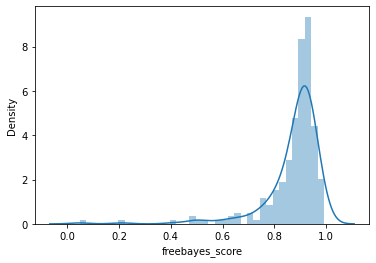

127
(1114, 31)


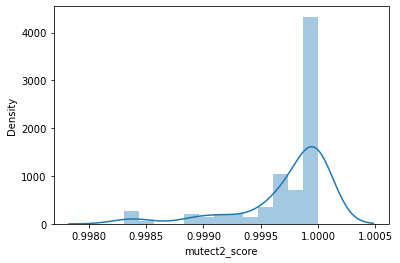

112
(1002, 31)


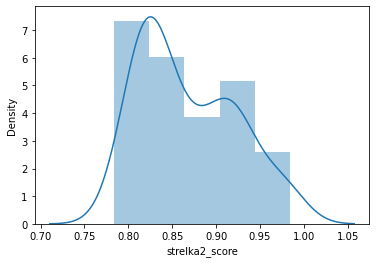

101
(901, 31)


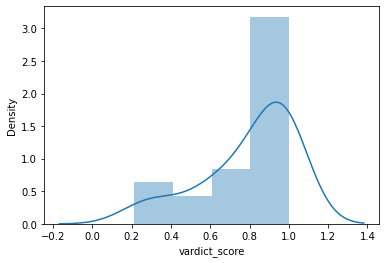

91
(810, 31)


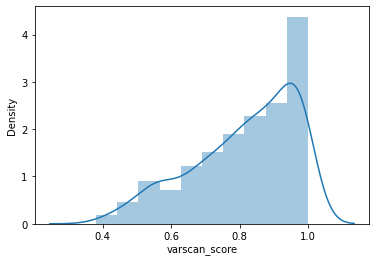

In [33]:
for m in config.methods:
    sns.distplot(tissue_negative_exome_df[m+'_score'].dropna())
    nlen = tissue_negative_exome_df[m+'_score'].shape[0]
    idxtodrop = tissue_negative_exome_df[m+'_score'].sort_values().index[int(0.9*nlen):] # remove 10% most confident calls for each method
    print(len(idxtodrop))
    tissue_negative_exome_df.drop(idxtodrop, inplace=True)
    print(tissue_negative_exome_df.shape)
    plt.show()

In [34]:
print(tissue_negative_exome_df.shape)

(810, 31)


In [35]:
# get high ctDNA sample calls
calltable_snv, calltable_indel , calltable_snp = get_calltable(os.path.join('data', 'initialsamples',  'NCC_CRC-986_100215_CW_T'), config.methods, save=True, filter='all')
print(calltable_snv.shape)
calltable_snv.head()

NCC_CRC-986_100215_CW_T
freebayes
mutect2
retrieving mutect2 0 calls with MinAF tags out of 41101
strelka2
retrieving strelka2 28757 calls with MinAF tags out of 19249
vardict
retrieving vardict 0 calls with f0.01;REJECT;REJECT tags out of 61552
varscan
calls for caller varscan do not exist. path data/initialsamples/NCC_CRC-986_100215_CW_T/calls/bcbio/NCC_CRC-986_100215_CW_T-N-germline-gatk-haplotype-annotated.vcf.gz not found.
cannot use GATK Haplotype calls to filter germline calls
final shape SNV: (152892, 30)
final shape INDEL: (88338, 30)
final shape SNP: (140956, 30)
(152892, 30)


,chrom,pos,ref,alt,type,freebayes,freebayes_score,mutect2,mutect2_score,strelka2,...,mutect2_vaf,strelka2_altcov,strelka2_totcov,strelka2_vaf,vardict_altcov,vardict_totcov,vardict_vaf,varscan_altcov,varscan_totcov,varscan_vaf
chrom_pos_ref_alt,,,,,,,,,,,,,,,,,,,,,
10_100031904_C_T,10,100031904,C,T,SNV,True,0.894449,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10_100031918_T_C,10,100031918,T,C,SNV,True,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10_100031924_TG_CA,10,100031924,TG,CA,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,0.0,60.0,0.0,NaN,NaN,NaN
10_100031924_T_C,10,100031924,T,C,SNV,True,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10_100031925_G_A,10,100031925,G,A,SNV,True,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# get highctDNA sample trusted mutations in exome

# weak mutations 1 caller

highctdna_list = []
for calltable in [calltable_snv, calltable_indel , calltable_snp]:
    highctdna_tmp_df = calltable[calltable[config.methods].sum(axis=1) == 1] # only 1 DNA caller
    print(highctdna_tmp_df.shape)
    highctdna_list.append(highctdna_tmp_df)
highctdna_negative_df = pd.concat(highctdna_list)
highctdna_negative_df['chrom_pos'] = highctdna_negative_df['chrom'].astype('str').str.cat(highctdna_negative_df['pos'].astype('str'), sep="_")

mutpos_negative_hightctdna = list(highctdna_negative_df.index)
print(len(mutpos_negative_hightctdna))

highctdna_negative_exome_df = highctdna_negative_df[highctdna_negative_df['chrom_pos'].isin(exomebed_itemlist_unique)]

mutpos_negative_exome_hightctdna = list(highctdna_negative_exome_df.index)
print(len(mutpos_negative_exome_hightctdna))

print(highctdna_negative_exome_df.shape)
highctdna_negative_exome_df.head()

(135892, 30)
(79711, 30)
(119687, 30)
335290
1289
(1289, 31)


,chrom,pos,ref,alt,type,freebayes,freebayes_score,mutect2,mutect2_score,strelka2,...,strelka2_altcov,strelka2_totcov,strelka2_vaf,vardict_altcov,vardict_totcov,vardict_vaf,varscan_altcov,varscan_totcov,varscan_vaf,chrom_pos
chrom_pos_ref_alt,,,,,,,,,,,,,,,,,,,,,
10_101473728_C_A,10,101473728,C,A,SNV,True,0.74538,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10_101473728
10_101979086_C_T,10,101979086,C,T,SNV,False,NaN,False,NaN,True,...,0.0,55.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10_101979086
10_101989268_G_A,10,101989268,G,A,SNV,False,NaN,False,NaN,True,...,0.0,71.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10_101989268
10_102749525_G_A,10,102749525,G,A,SNV,False,NaN,False,NaN,True,...,0.0,66.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10_102749525
10_103920064_G_A,10,103920064,G,A,SNV,False,NaN,False,NaN,True,...,0.0,110.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10_103920064


In [38]:
# Number of weak mutations detected

mutpos_negative_exome_tissue = list(tissue_negative_exome_df.index)
print(len(mutpos_negative_exome_tissue))

mutpos_negative_exome_hightctdna = list(highctdna_negative_exome_df.index)
print(len(mutpos_negative_exome_hightctdna))

mutpos_negative_exome_both = list(set(mutpos_negative_exome_tissue) & set(mutpos_negative_exome_hightctdna))
print(len(mutpos_negative_exome_both))

mutpos_negative_exome_union = list(set(mutpos_negative_exome_tissue) | set(mutpos_negative_exome_hightctdna))
print(len(mutpos_negative_exome_union))

810
1289
20
2079


129
(1160, 31)


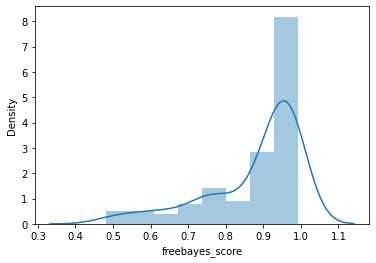

116
(1044, 31)


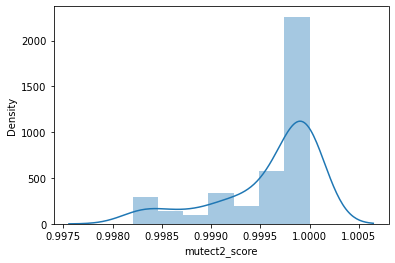

105
(939, 31)


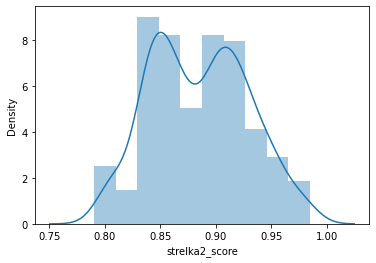

94
(845, 31)


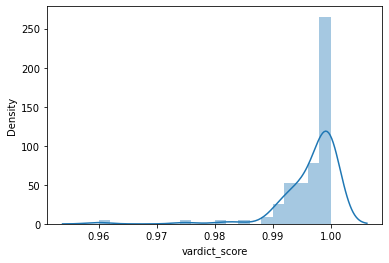

85
(760, 31)


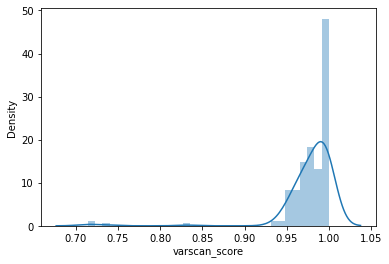

In [39]:
for m in config.methods:
    sns.distplot(highctdna_negative_exome_df[m+'_score'].dropna())
    nlen = highctdna_negative_exome_df[m+'_score'].shape[0]
    idxtodrop = highctdna_negative_exome_df[m+'_score'].sort_values().index[int(0.9*nlen):] # remove 10% most confident calls for each method
    print(len(idxtodrop))
    highctdna_negative_exome_df.drop(idxtodrop, inplace=True)
    print(highctdna_negative_exome_df.shape)
    plt.show()

In [46]:
print(highctdna_negative_exome_df.shape)

(760, 31)


In [47]:
highctdna_exome_df

,chrom,pos,ref,alt,type,freebayes,freebayes_score,mutect2,mutect2_score,strelka2,...,strelka2_altcov,strelka2_totcov,strelka2_vaf,vardict_altcov,vardict_totcov,vardict_vaf,varscan_altcov,varscan_totcov,varscan_vaf,chrom_pos
chrom_pos_ref_alt,,,,,,,,,,,,,,,,,,,,,
11_64545497_C_T,11,64545497,C,T,SNV,True,0.969072,True,1.000000,True,...,0.0,46.0,0.0,0.0,34.0,0.0,NaN,NaN,NaN,11_64545497
13_47470350_C_T,13,47470350,C,T,SNV,False,NaN,True,1.000000,True,...,0.0,53.0,0.0,0.0,35.0,0.0,0.0,30.0,0.0,13_47470350
13_73357855_C_T,13,73357855,C,T,SNV,True,0.850184,True,0.999996,True,...,0.0,41.0,0.0,0.0,36.0,0.0,NaN,NaN,NaN,13_73357855
13_73636650_C_T,13,73636650,C,T,SNV,True,0.990459,True,1.000000,True,...,0.0,86.0,0.0,0.0,61.0,0.0,0.0,49.0,0.0,13_73636650
15_84488603_G_T,15,84488603,G,T,SNV,True,0.990109,True,1.000000,True,...,0.0,84.0,0.0,0.0,51.0,0.0,NaN,NaN,NaN,15_84488603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8_22471675_G_A,8,22471675,G,A,SNP,True,0.937477,True,1.000000,True,...,0.0,77.0,0.0,0.0,56.0,0.0,0.0,43.0,0.0,8_22471675
8_37732230_G_A,8,37732230,G,A,SNP,True,0.990164,True,1.000000,True,...,0.0,81.0,0.0,0.0,51.0,0.0,0.0,43.0,0.0,8_37732230
8_54142294_C_T,8,54142294,C,T,SNP,True,0.991654,True,1.000000,True,...,0.0,61.0,0.0,0.0,44.0,0.0,NaN,NaN,NaN,8_54142294


In [67]:
negative_positions = list(highctdna_negative_exome_df.chrom_pos.values)
positive_positions = list(highctdna_exome_df.chrom_pos.values) + list(retrieved_pos.chrom_pos.values)
print(len(positive_positions))

# Check negative positions do not contain positive positions
for i in positive_positions:
    if i in negative_positions:
        print(i)
        negative_positions.remove(i)
        
# Are negative events too close to positive events?
n = 0
for pet in positive_positions:
    chrom, pos = pet.split('_')
    pos = int(pos)
    for p in range(pos-1500, pos+1500):
        if chrom+'_'+str(p) in negative_positions:
            print(pet, chrom+'_'+str(p))
            n += 1
            negative_positions.remove(chrom+'_'+str(p))
print('{} negative events are too close from positive events'.format(n))

print(len(negative_positions))

94
11_48347424
12_7459300
1_33145657 1_33145977
16_85589612 16_85589434
16_85589612 16_85589497
3 negative events are too close from positive events
755


In [16]:
# Which method is called?

print(tissue_negative_exome_df[config.methods].sum())
print(highctdna_negative_exome_df[config.methods].sum())

freebayes    387
mutect2      118
strelka2      75
vardict      320
varscan      530
dtype: int64
freebayes    224
mutect2      100
strelka2     436
vardict      136
varscan      393
dtype: int64


In [72]:
dataset_positions = positive_positions + negative_positions
dataset_positions_dict = {'locus':[], 'chrom':[], 'startpos':[], 'endpos':[]}
for dp in dataset_positions:
    dataset_positions_dict['locus'].append(dp)
    dataset_positions_dict['chrom'].append(dp.split('_')[0])
    dataset_positions_dict['startpos'].append(int(dp.split('_')[1])-150000)
    dataset_positions_dict['endpos'].append(int(dp.split('_')[1])+150000)
dataset_positions_df = pd.DataFrame(dataset_positions_dict)
dataset_positions_df.set_index('locus', inplace=True)
dataset_positions_df.sort_values(by=['chrom', 'startpos'], inplace=True)
dataset_positions_df

,chrom,startpos,endpos
locus,,,
1_935303,1,785303,1085303
1_979068,1,829068,1129068
1_1663709,1,1513709,1813709
1_2125498,1,1975498,2275498
1_3753058,1,3603058,3903058
...,...,...,...
X_135482126,X,135332126,135632126
X_139038632,X,138888632,139188632
X_147026350,X,146876350,147176350


In [74]:
# save positive and negative positions to bed file

dataset_positions_df.to_csv('data/exome/minibampositions.bed', index=False, sep='\t', header=None)